<a href="https://colab.research.google.com/github/siripatsorn6/Ikoma/blob/main/DIP_Lab2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Enhancement in Spatial Domain

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install -U pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 25.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [3]:
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 72.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.gray();
from matplotlib.pyplot import imshow

import skimage
from skimage.io import imread, imsave

from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_local
from skimage.exposure import histogram, adjust_gamma, cumulative_distribution
from skimage.morphology import square
from skimage import measure, color, morphology, data, img_as_float, img_as_ubyte, exposure, io, color
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma


from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from PIL import Image, ImageEnhance, ImageFilter
from scipy import ndimage, misc
import matplotlib.pylab as pylab

import cv2

import numpy as np

from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display

/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


<Figure size 432x288 with 0 Axes>

# การปรับความเข้มแสงโดยใช้ฟังค์ชันยกกำลัง (Power -law function)
การแก้ไขด้วยฟังค์ชันแกรมม่า 


In [5]:
files=['/gdrive/My Drive/images/flower.JPG']
@interact(gamma=(0.1, 10, 0.1),
          file=files)
def g(gamma=1.0, file=files[0]):
   #รูปภาพสี่ช่องสัญญาณ (4 channel) : ตัวอย่างเช่น ภาพ RGBA แต่ละพิกเซลจะแสดงด้วยค่า tuple สามค่า (r, g, b, α ) ซึ่งเป็นช่องสัญญาณสุดท้ายที่แสดงถึงความโปร่งใส
  im = rgb2gray(imread(file)[:,:,:3])  # บรรทัดนี้จะสกัดเฉพาะ RGB
  fig = plt.figure(figsize=(20, 3))
  ax = fig.add_subplot(1, 4, 1)
  imshow(im, vmin=0, vmax=1)
  plt.colorbar()
  plt.title('original image')
    
  ax = fig.add_subplot(1, 4, 2)
  im_gamma = adjust_gamma(im, gamma)
  imshow(im_gamma, vmin=0, vmax=1)
  plt.colorbar()
  plt.title('$\gamma$ = {}'.format(gamma))
    
  ax = fig.add_subplot(1, 4, 3)
  x = np.arange(0, 1, 0.01)
  plt.plot(x, x ** gamma)
  
  pylab.xlabel('input', size=20), pylab.ylabel('output', size=20)
  pylab.title('$\gamma$ = {}'.format(gamma))

  ax = fig.add_subplot(1, 4, 4)  
  freq, bins = histogram(im_gamma)
  plt.plot(bins, freq)
  plt.xlim(0, 1)
  pylab.xlabel('intensity', size=20), pylab.ylabel('frequency', size=20),pylab.yscale('log')
  pylab.title('histogram (log)')


  plt.show();

interactive(children=(FloatSlider(value=1.0, description='gamma', max=10.0, min=0.1), Dropdown(description='fi…

In [6]:
vals = (val_start, val_end, val_step) = 0.1, 10, 0.1
val_default = 1.0

files = ['/gdrive/My Drive/images/flower.JPG']

@interact(r_gamma=vals,
          g_gamma=vals,
          b_gamma=vals,
          file=files)
def g(r_gamma=val_default,
      g_gamma=val_default,
      b_gamma=val_default,
      file=files[0]):
    
    im = imread(file)[:,:,:3]  
    
    fig = plt.figure(figsize=(15, 3))

    ax = fig.add_subplot(1, 3, 1)
    imshow(im, vmin=0, vmax=255)
    plt.title('original image')
    
    ax = fig.add_subplot(1, 3, 2)
    im[:, :, 0] = 255 * (im[:, :, 0]/255) ** r_gamma
    im[:, :, 1] = 255 * (im[:, :, 1]/255) ** g_gamma
    im[:, :, 2] = 255 * (im[:, :, 2]/255) ** b_gamma
    imshow(im, vmin=0, vmax=1)
    plt.title('$\gamma$ = ({0},{1},{2})'.format(r_gamma, g_gamma, b_gamma))
    
    ax = fig.add_subplot(1, 3, 3)
    x = np.arange(0, 1, 0.01)
    plt.plot(x, x ** r_gamma, c='red', label='$\gamma$ for R')
    plt.plot(x, x ** g_gamma, c='green', label='$\gamma$ for G')
    plt.plot(x, x ** b_gamma, c='blue', label='$\gamma$ for B')
    plt.legend()
    ax.set_aspect('equal')
    ax.set_xlabel('input')
    ax.set_ylabel('output')

    plt.show();



interactive(children=(FloatSlider(value=1.0, description='r_gamma', max=10.0, min=0.1), FloatSlider(value=1.0,…

## การปรับค่าความเข้มแสงโดยใช้ฟังค์ชันเส้นตรง (Linear Function)
ในกรณีที่ปรับความเข้มแสง ตั้งแต่ค่า 0 จนถึง ค่า อ้างอิง Threshold เรียกเทคนิคนี้ว่า thresholding

In [7]:
files=['/gdrive/My Drive/images/flower.JPG']

@interact(global_th=(0, 200, 50),
          file=files)
def g(global_th=200, file=files[0]):
   
  im = Image.open(file).convert('L') 
  im = Image.fromarray(np.clip(im + np.random.randint(-128, 128, (im.height, im.width)), 0, 255).astype(np.uint8))
  fig = plt.figure(figsize=(20, 3))
  ax = fig.add_subplot(1, 4, 1)
  imshow(im)
  plt.colorbar()
  plt.title('original image')
    
  ax = fig.add_subplot(1, 4, 2)
  #global_th = threshold_otsu(im)
  binary_global = im.point(lambda x: x > global_th)
  imshow(binary_global)
  plt.colorbar()
  plt.title('binary image with threshold=' + str(global_th))
 
  

interactive(children=(IntSlider(value=200, description='global_th', max=200, step=50), Dropdown(description='f…

# Contrast stretching and histogram equalization with scikit-image
กระบวนการที่ขยายช่วงของระดับความเข้มแสงในภาพเพื่อที่จะปรับช่วงของความเข้มแสง


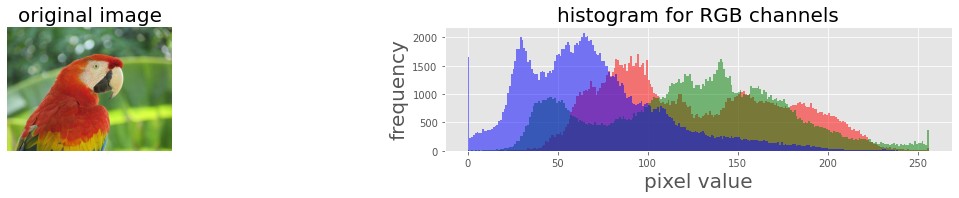

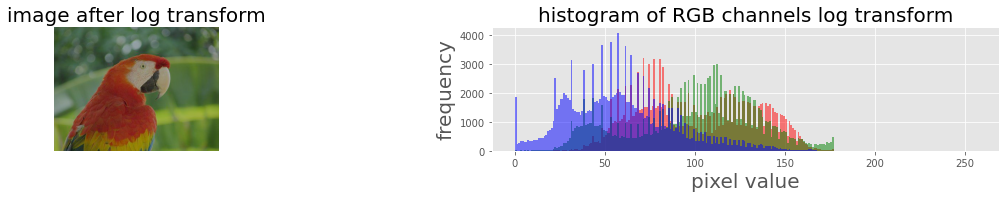

In [9]:
def plot_image(image, title=''):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis('off') # comment this line if you want axis ticks

def plot_hist(r, g, b, title=''):
    r, g, b = img_as_ubyte(r), img_as_ubyte(g), img_as_ubyte(b)
    pylab.hist(np.array(r).ravel(), bins=256, range=(0, 256), color='r', alpha=0.5)
    pylab.hist(np.array(g).ravel(), bins=256, range=(0, 256), color='g', alpha=0.5)
    pylab.hist(np.array(b).ravel(), bins=256, range=(0, 256), color='b', alpha=0.5)
    pylab.xlabel('pixel value', size=20), pylab.ylabel('frequency', size=20)
    pylab.title(title, size=20)

im = Image.open("/gdrive/My Drive/images/parrot.png")
im_r, im_g, im_b = im.split()
pylab.style.use('ggplot')
pylab.figure(figsize=(20,5))
pylab.subplot(221), plot_image(im, 'original image')
pylab.subplot(222), plot_hist(im_r, im_g, im_b,'histogram for RGB channels')
pylab.show()
im = im.point(lambda i: 255*np.log(1+i/255))
im_r, im_g, im_b = im.split()
pylab.style.use('ggplot')
pylab.figure(figsize=(20,5))
pylab.subplot(223), plot_image(im, 'image after log transform')
pylab.subplot(224), plot_hist(im_r, im_g, im_b, 'histogram of RGB channels log transform')
pylab.show()

<Figure size 432x288 with 0 Axes>

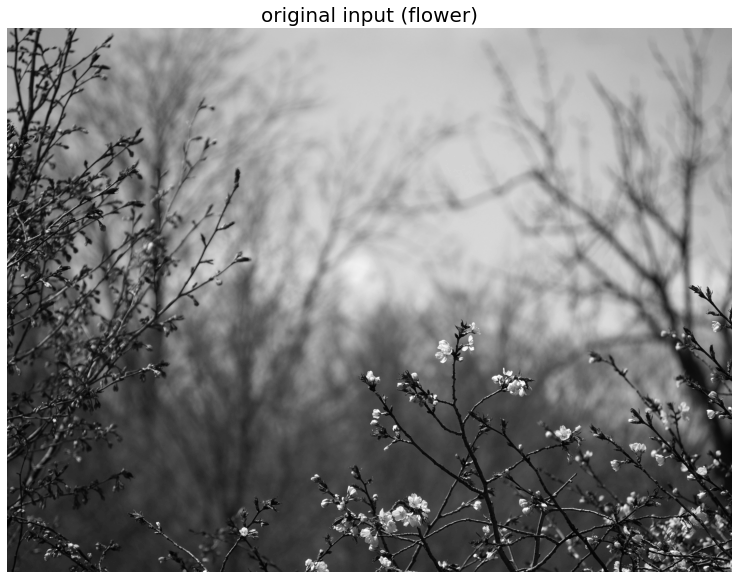

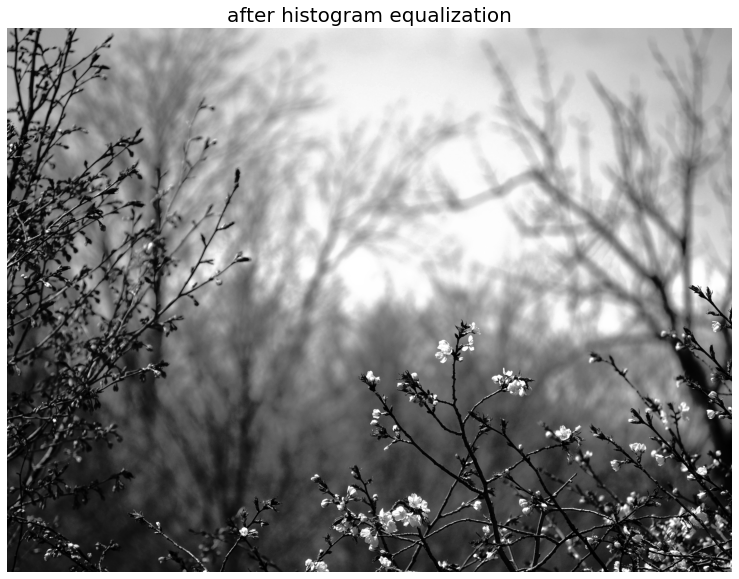

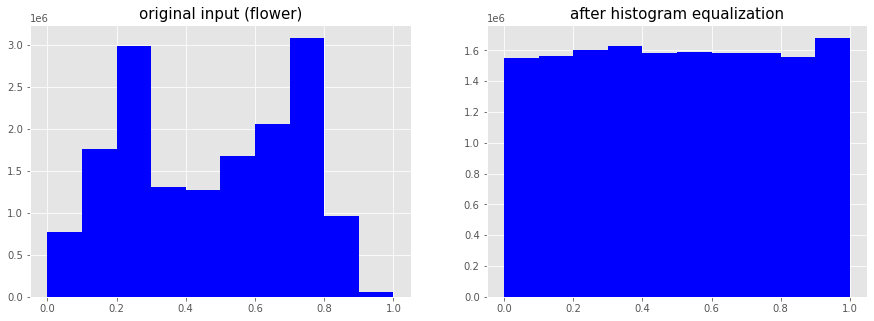

In [10]:
img = rgb2gray(imread('/gdrive/My Drive/images/flower.JPG'))
# histogram equalization
img_eq = exposure.equalize_hist(img)
# adaptive histogram equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
pylab.gray()
images = [img, img_eq]
titles = ['original input (flower)', 'after histogram equalization']
for i in range(2):
    pylab.figure(figsize=(20,10)), plot_image(images[i], titles[i])
pylab.figure(figsize=(15,5))
for i in range(2):
    pylab.subplot(1,2,i+1), pylab.hist(images[i].ravel(), color='b'), pylab.title(titles[i], size=15)
pylab.show()

<ipython-input-11-96d3469b6fb6>:26: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 4), dtype = np.object)


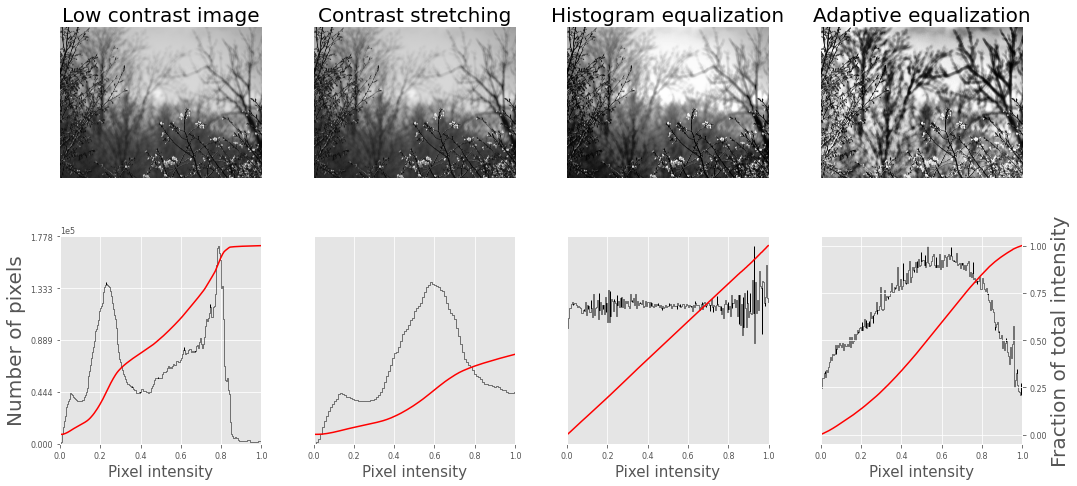

In [11]:
import matplotlib
matplotlib.rcParams['font.size'] = 8
def plot_image_and_hist(image, axes, bins=256):
    image = img_as_float(image)
    axes_image, axes_hist = axes
    axes_cdf = axes_hist.twinx()
    axes_image.imshow(image, cmap=pylab.cm.gray)
    axes_image.set_axis_off()
    axes_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    axes_hist.set_xlim(0, 1)
    axes_hist.set_xlabel('Pixel intensity', size=15)
    axes_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    axes_hist.set_yticks([])
    image_cdf, bins = exposure.cumulative_distribution(image, bins)
    axes_cdf.plot(bins, image_cdf, 'r')
    axes_cdf.set_yticks([])
    return axes_image, axes_hist, axes_cdf

im = rgb2gray(io.imread('/gdrive/My Drive/images/flower.JPG'))
# contrast stretching
im_rescale = exposure.rescale_intensity(im, in_range=(0, 100), out_range=(0, 255))
im_eq = exposure.equalize_hist(im) # histogram equalization
im_adapteq = exposure.equalize_adapthist(im, clip_limit=0.03) # adaptive histogram equalization

fig = pylab.figure(figsize=(15, 7))
axes = np.zeros((2, 4), dtype = np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)
axes_image, axes_hist, axes_cdf = plot_image_and_hist(im, axes[:, 0])
axes_image.set_title('Low contrast image', size=20)
y_min, y_max = axes_hist.get_ylim()
axes_hist.set_ylabel('Number of pixels', size=20)
axes_hist.set_yticks(np.linspace(0, y_max, 5))
axes_image, axes_hist, axes_cdf = plot_image_and_hist(im_rescale, axes[:,1])
axes_image.set_title('Contrast stretching', size=20)
axes_image, axes_hist, axes_cdf = plot_image_and_hist(im_eq, axes[:, 2])
axes_image.set_title('Histogram equalization', size=20)
axes_image, axes_hist, axes_cdf = plot_image_and_hist(im_adapteq, axes[:,3])
axes_image.set_title('Adaptive equalization', size=20)
axes_cdf.set_ylabel('Fraction of total intensity', size=20)
axes_cdf.set_yticks(np.linspace(0, 1, 5))
fig.tight_layout()
pylab.show()

In [13]:
def plot_image(image, title=''):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis('off') # comment this line if you want axis ticks
def plot_hist(r, g, b, title=''):
    r, g, b = img_as_ubyte(r), img_as_ubyte(g), img_as_ubyte(b)
    pylab.hist(np.array(r).ravel(), bins=256, range=(0, 256), color='r', alpha=0.5)
    pylab.hist(np.array(g).ravel(), bins=256, range=(0, 256), color='g', alpha=0.5)
    pylab.hist(np.array(b).ravel(), bins=256, range=(0, 256), color='b', alpha=0.5)
    pylab.xlabel('pixel value', size=20), pylab.ylabel('frequency', size=20)
    pylab.title(title, size=20)

 Piecewise Contrast Stretch เป็นการยืดระดับค่าสีเทาของข้อมูลภาพเป็นช่วงที่เฉพาะเจาะจง ค่าพิสับของระดับสีเทาของข้อมูลเดิมจะขยายเป็นหลายช่วง


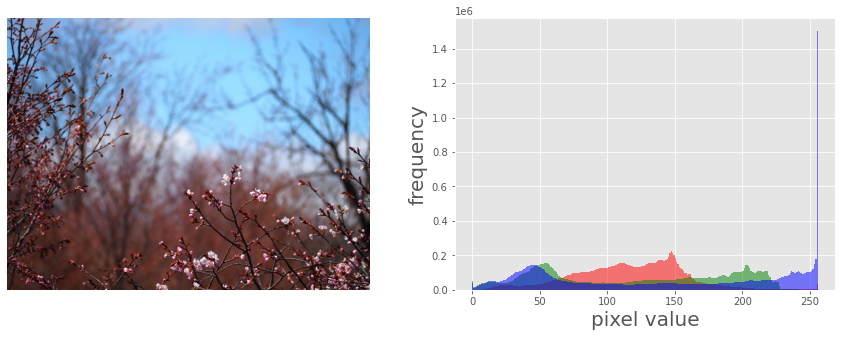

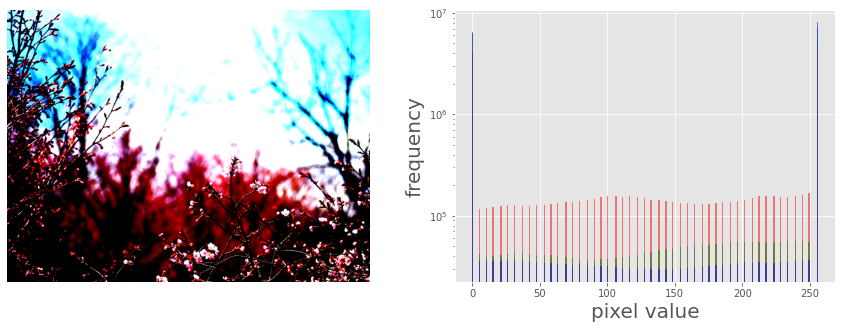

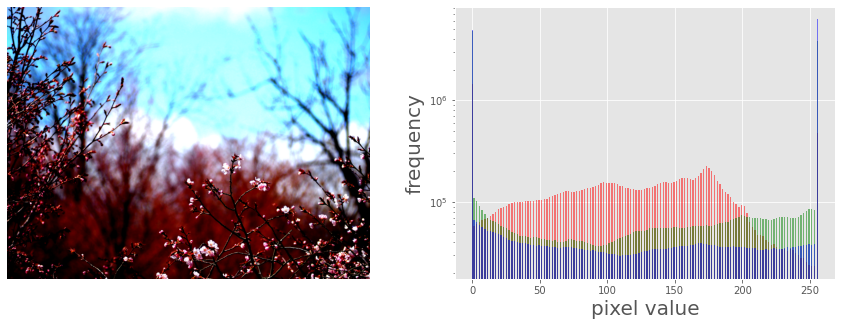

In [14]:
im = Image.open('/gdrive/My Drive/images/flower.JPG')
im_r, im_g, im_b = im.split()
pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121)
plot_image(im)
pylab.subplot(122)
plot_hist(im_r, im_g, im_b)
pylab.show()
def contrast(c):
    return 0 if c < 70 else (255 if c > 150 else (255*c - 22950) / 48)# piece-wise linear function

im1 = im.point(contrast)
im_r, im_g, im_b= im1.split()
pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121)
plot_image(im1)
pylab.subplot(122)
plot_hist(im_r, im_g, im_b)
pylab.yscale('log',basey=10)
pylab.show()

contrast = ImageEnhance.Contrast(im)
im1 = np.reshape(np.array(contrast.enhance(2).getdata()).astype(np.uint8), (im.height, im.width, 3)) 
pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121), plot_image(im1)
pylab.subplot(122), plot_hist(im1[...,0], im1[...,1], im1[...,2]), pylab.yscale('log',basey=10)
pylab.show()